In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
# import plotly.express as px
from tensorflow.keras import layers
from pickle import dump, load
from pathlib import Path
import plotly.figure_factory as ff
from scipy.spatial import Delaunay
import plotly.graph_objects as go
import plotly.offline as pyo
import chart_studio.plotly as py
from scipy.interpolate import griddata
import os
import wandb
from einops import rearrange
import json

In [3]:
api = wandb.Api()
entity, project = "rietta", "TFM_PruebasInv"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 


In [4]:
def load_table_from_artifact(artifact):
    with open(artifact.file()) as f:
        json_data = json.load(f)
    return pd.DataFrame(json_data["data"], columns=json_data["columns"])

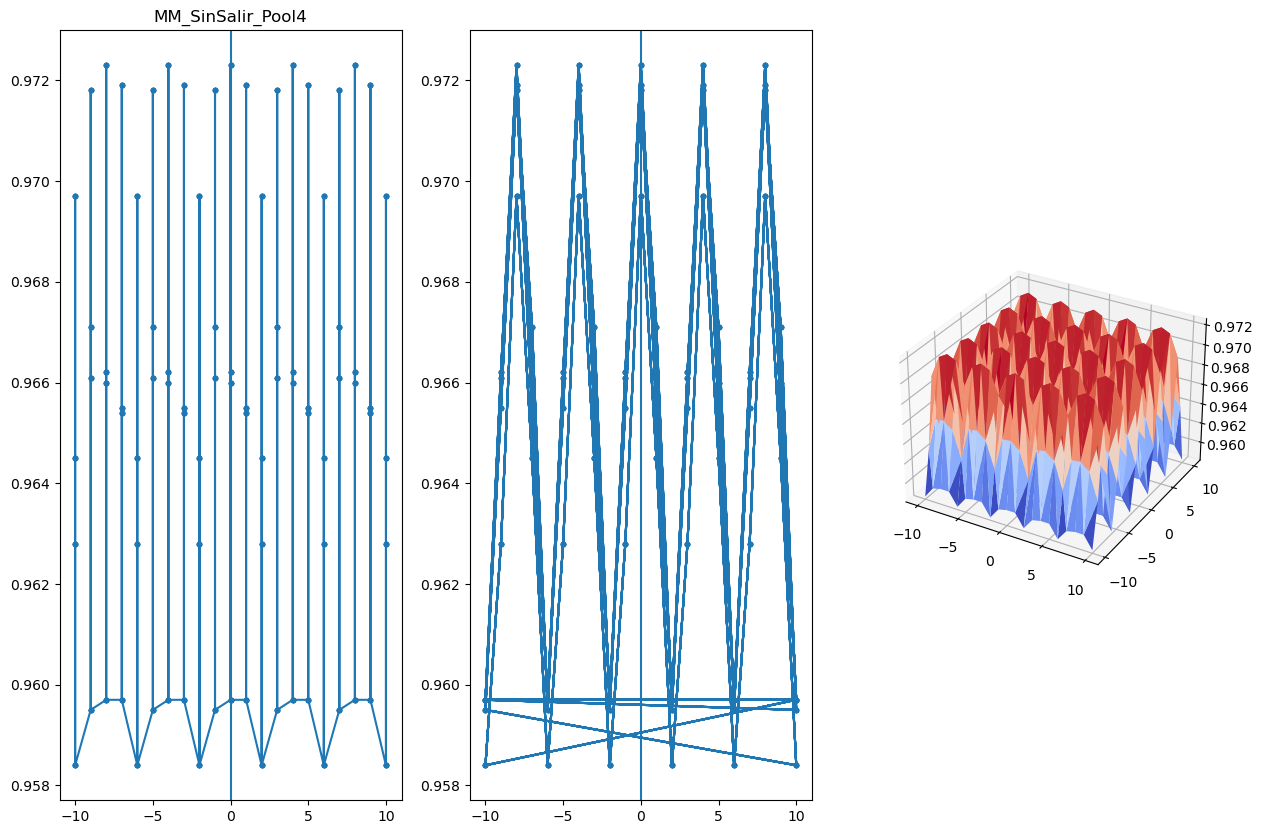

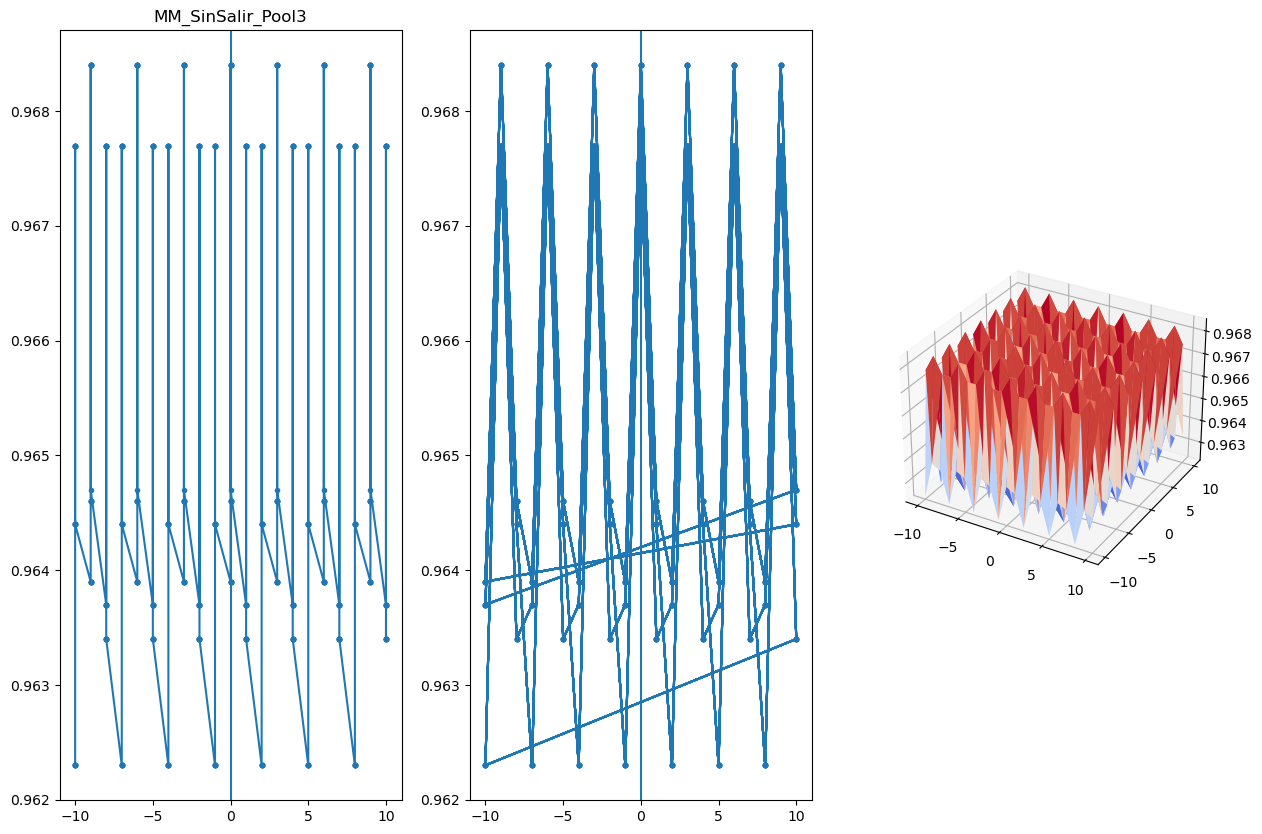

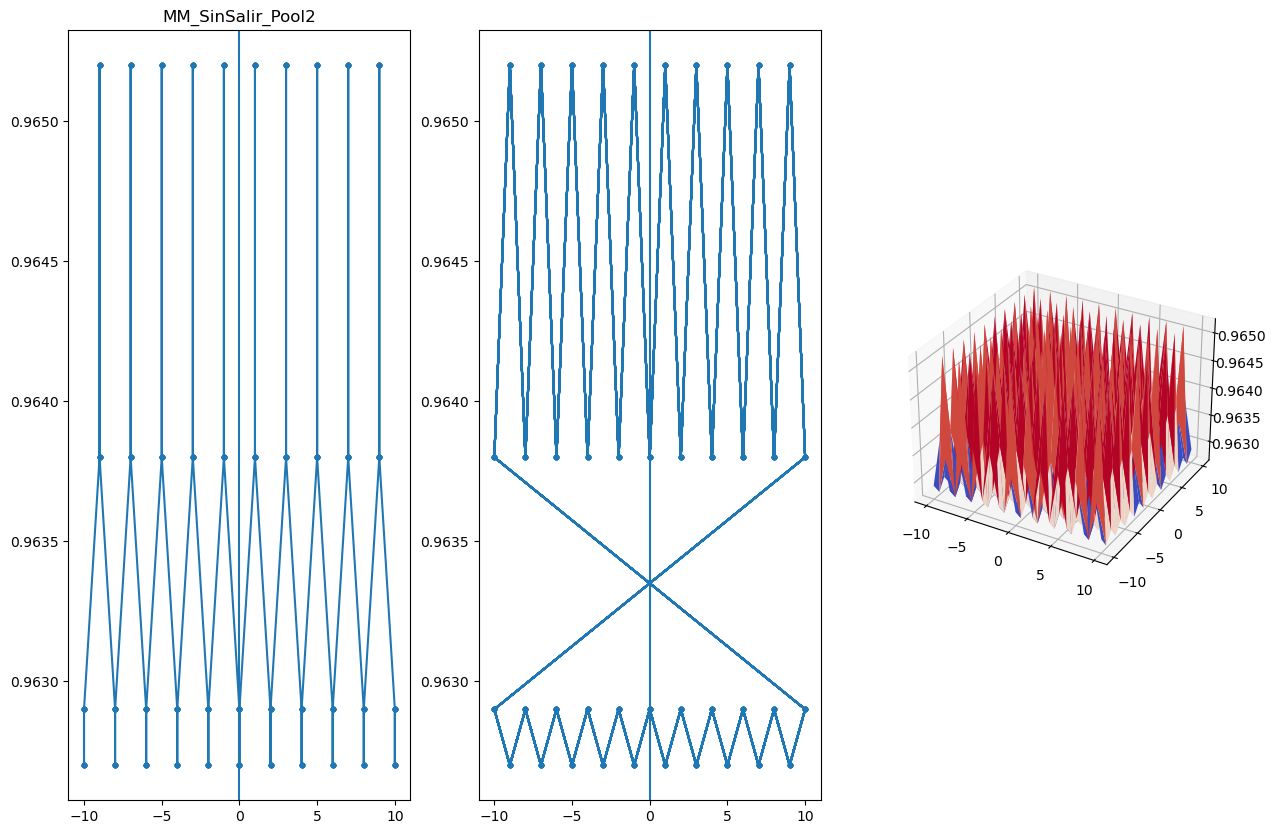

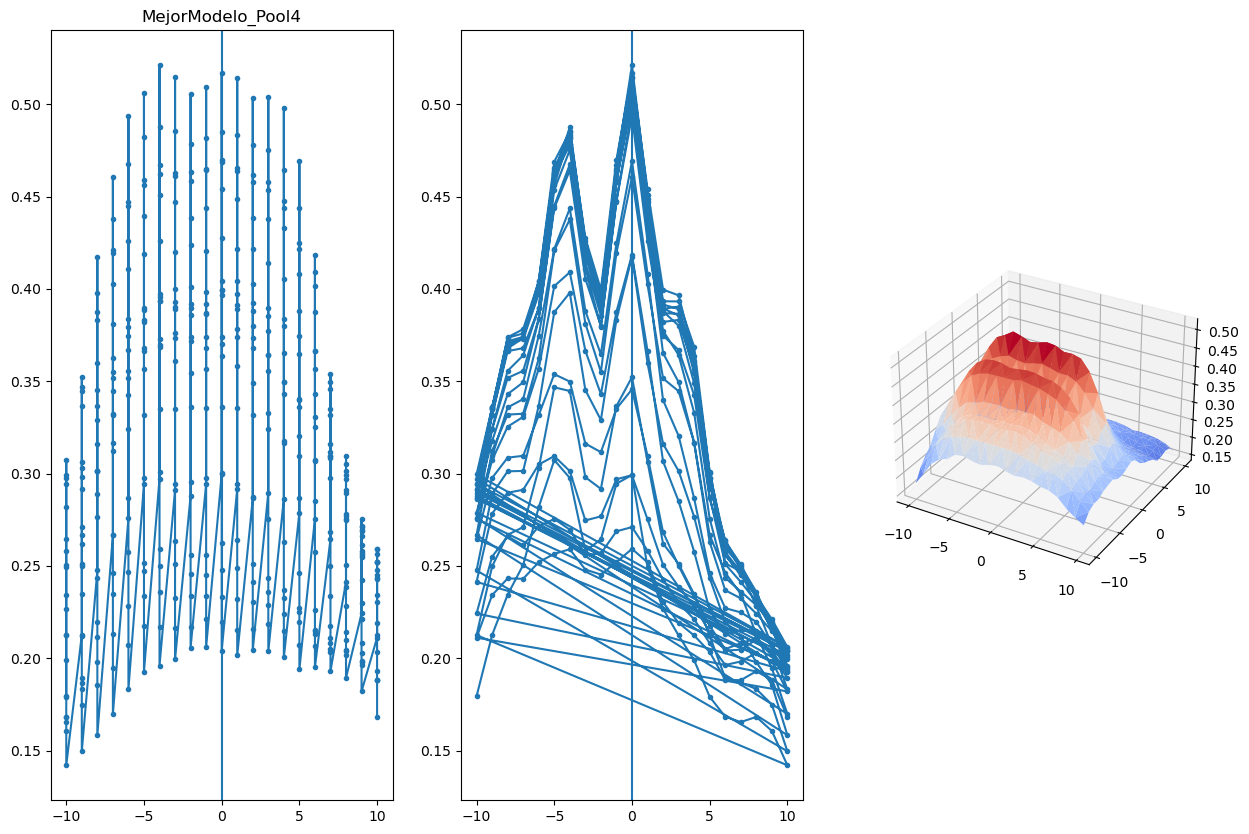

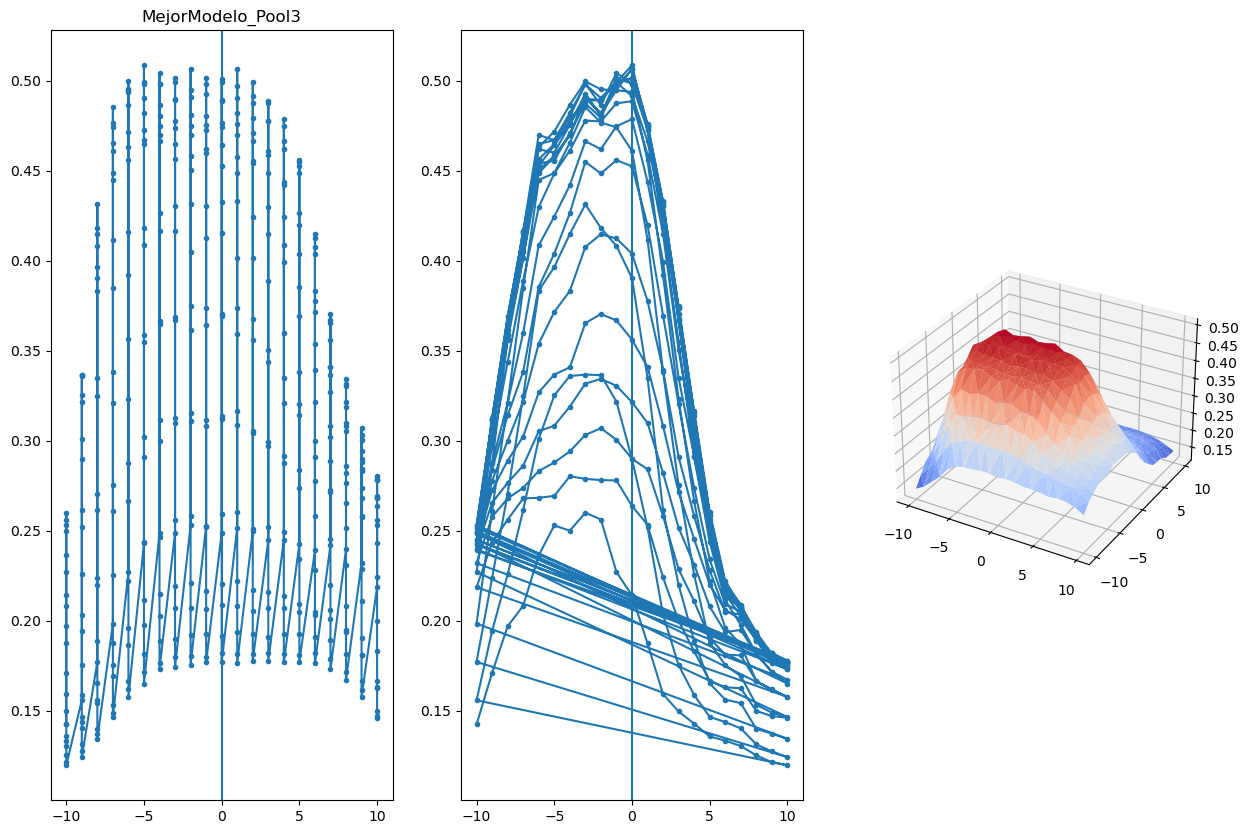

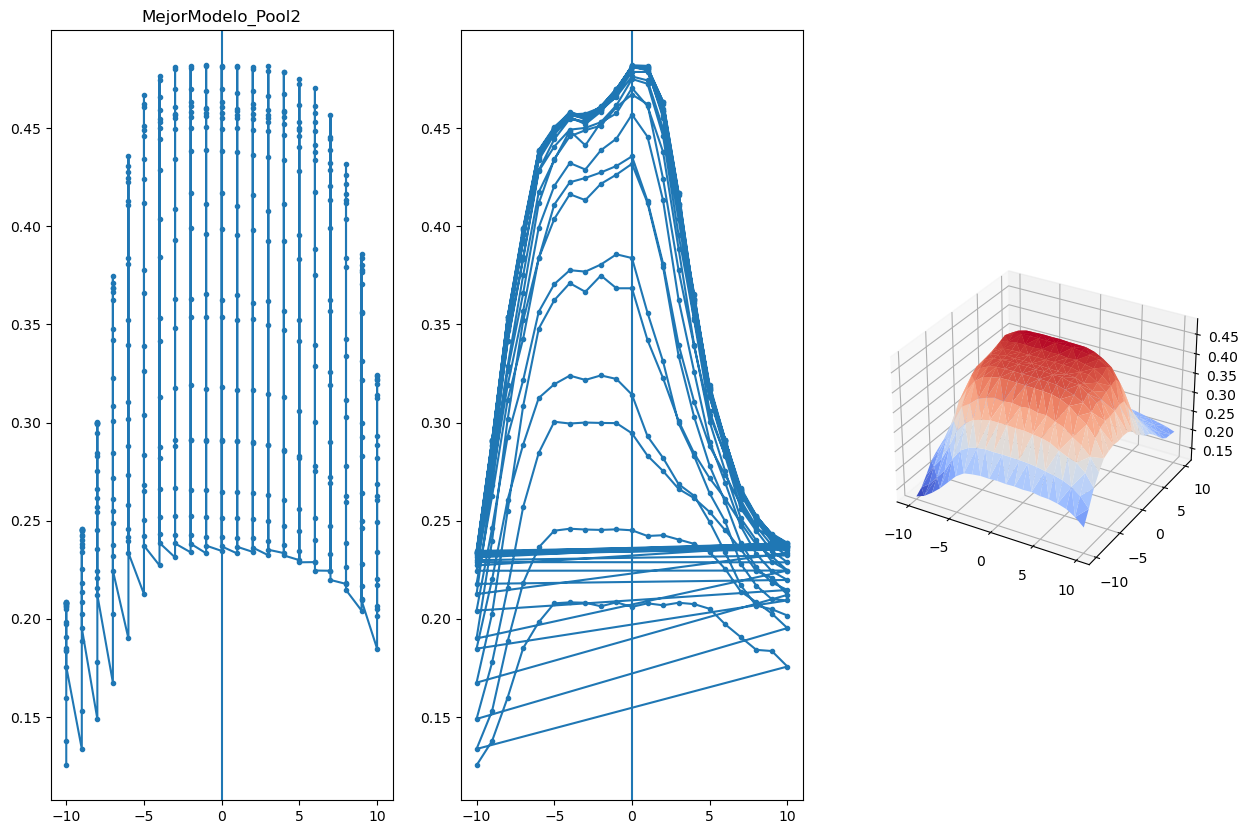

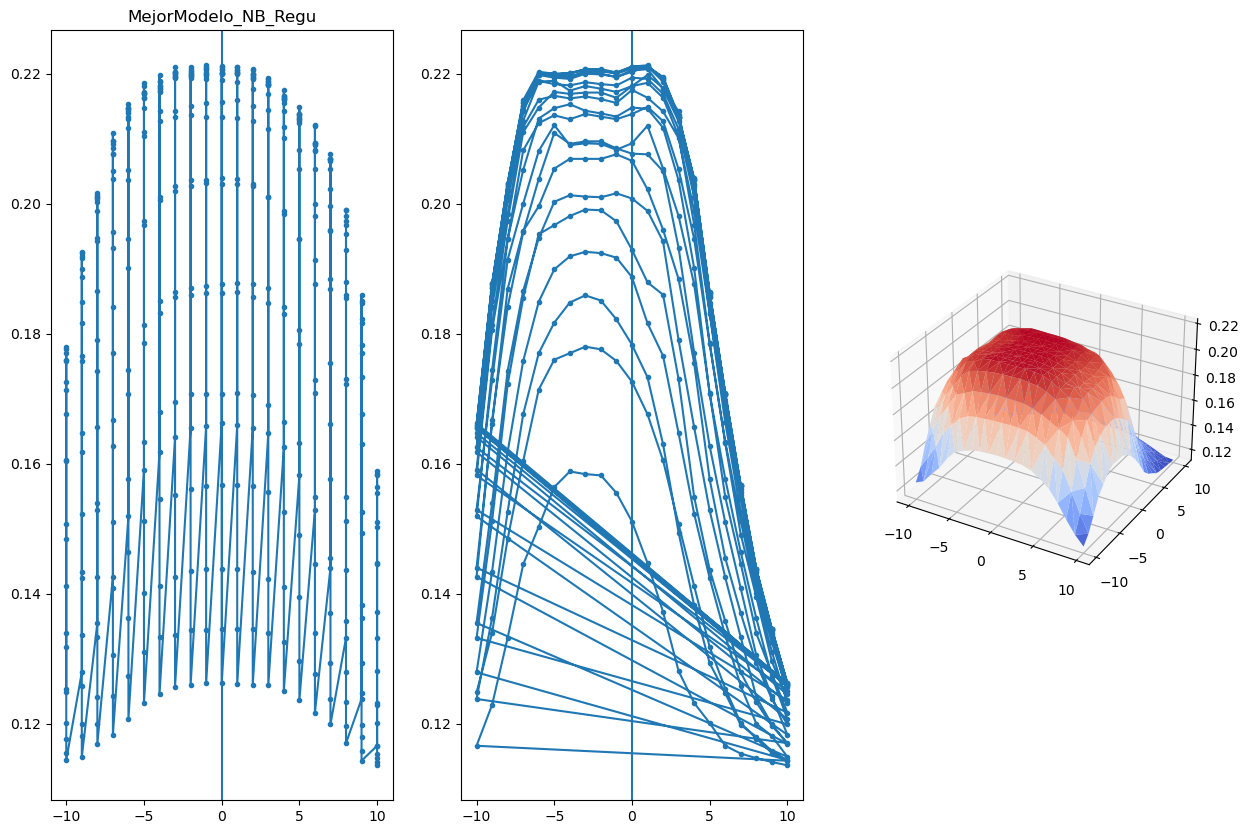

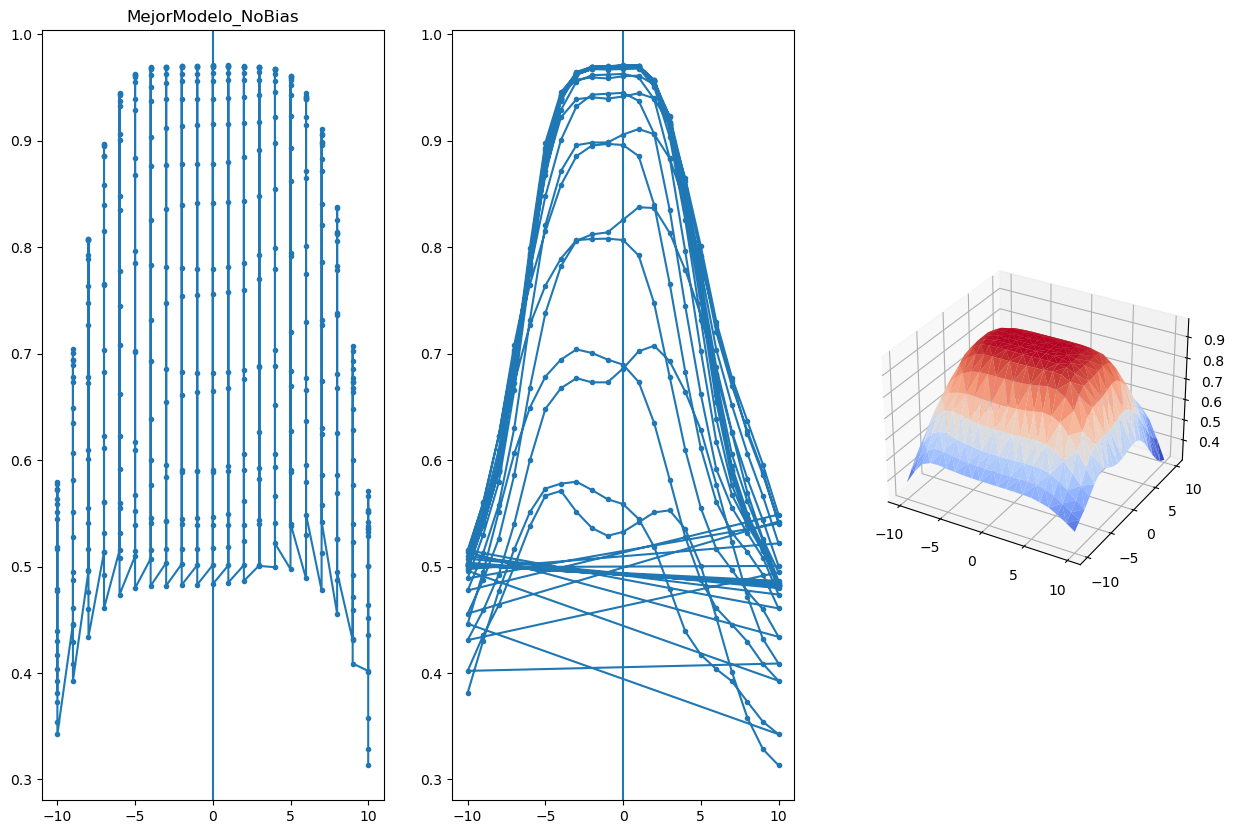

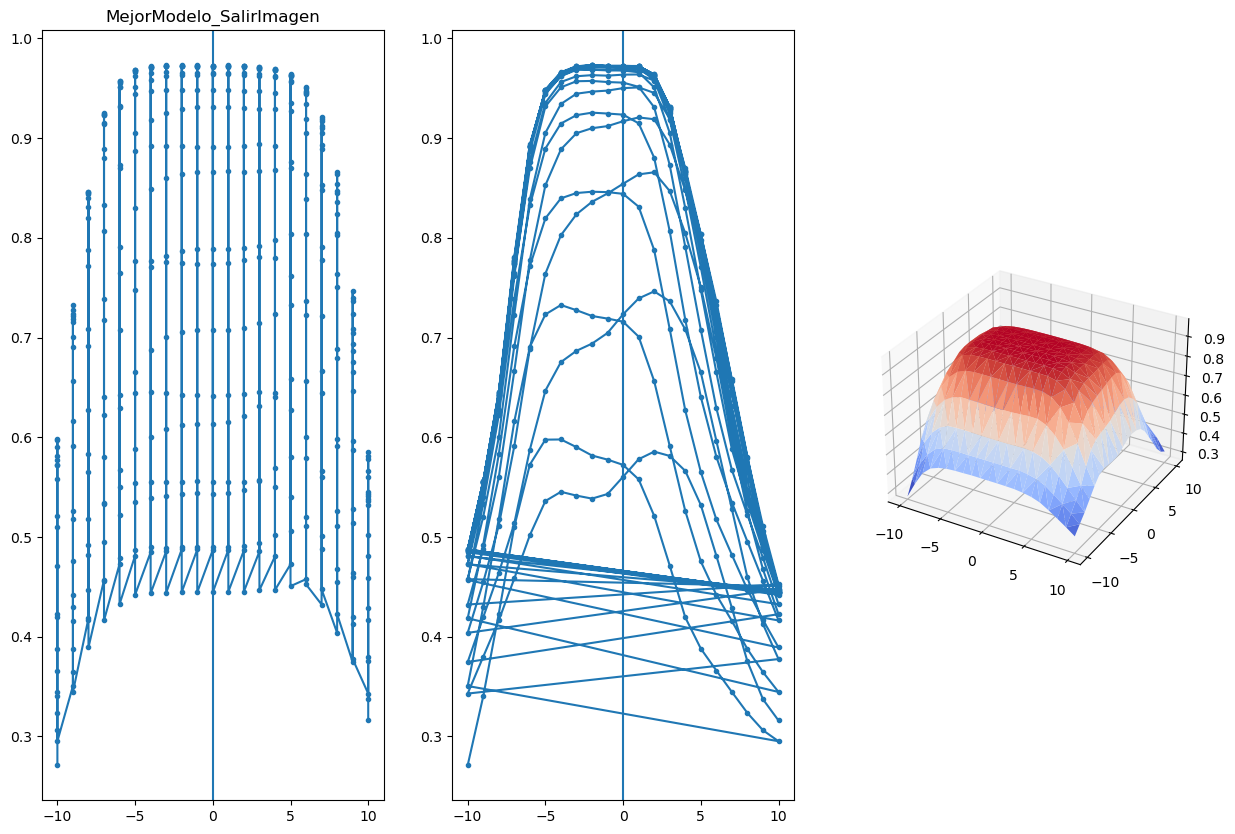

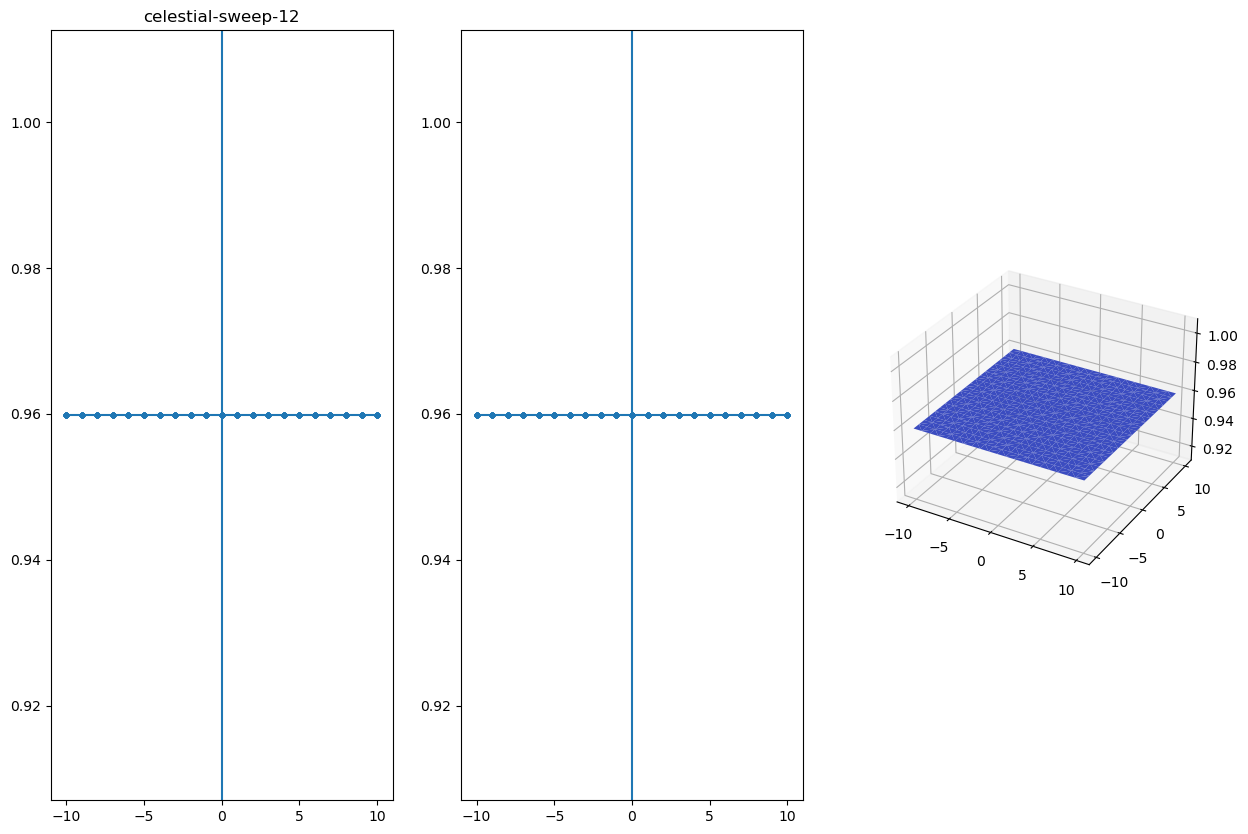

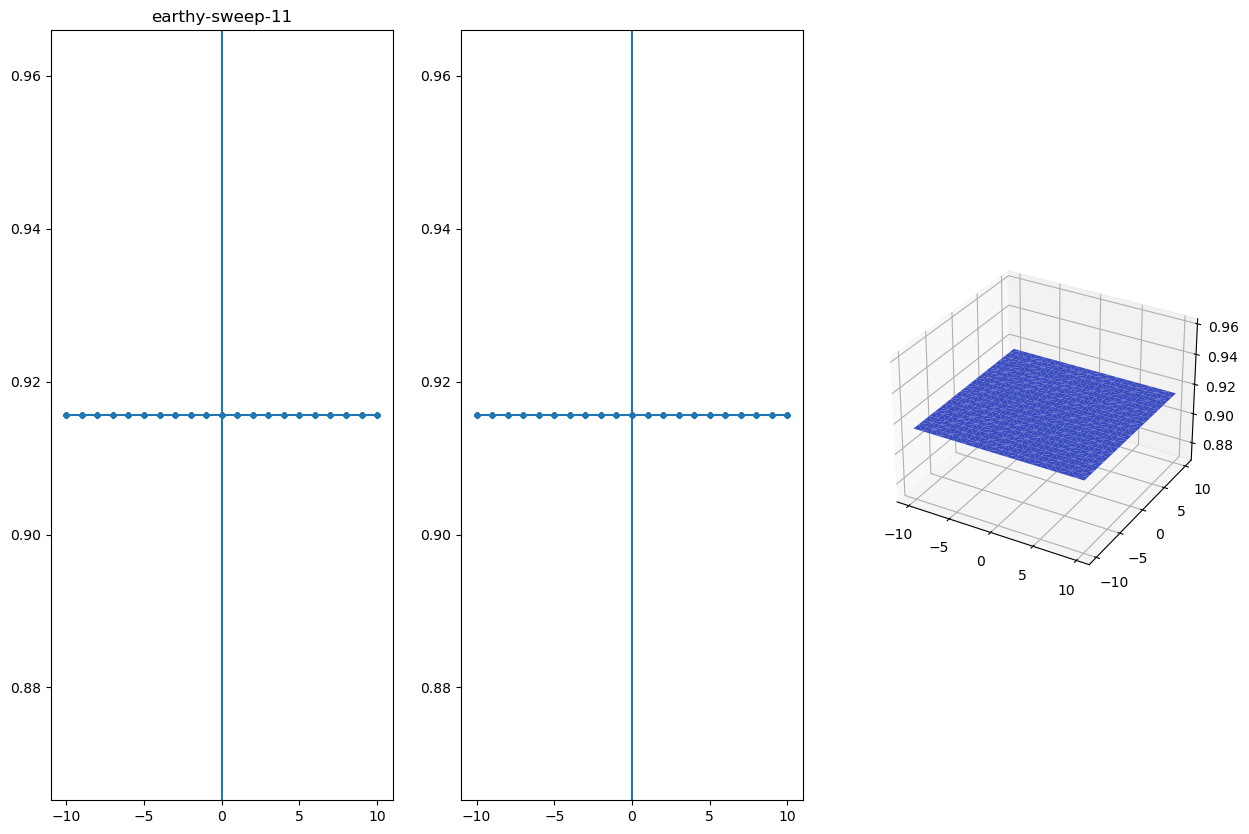

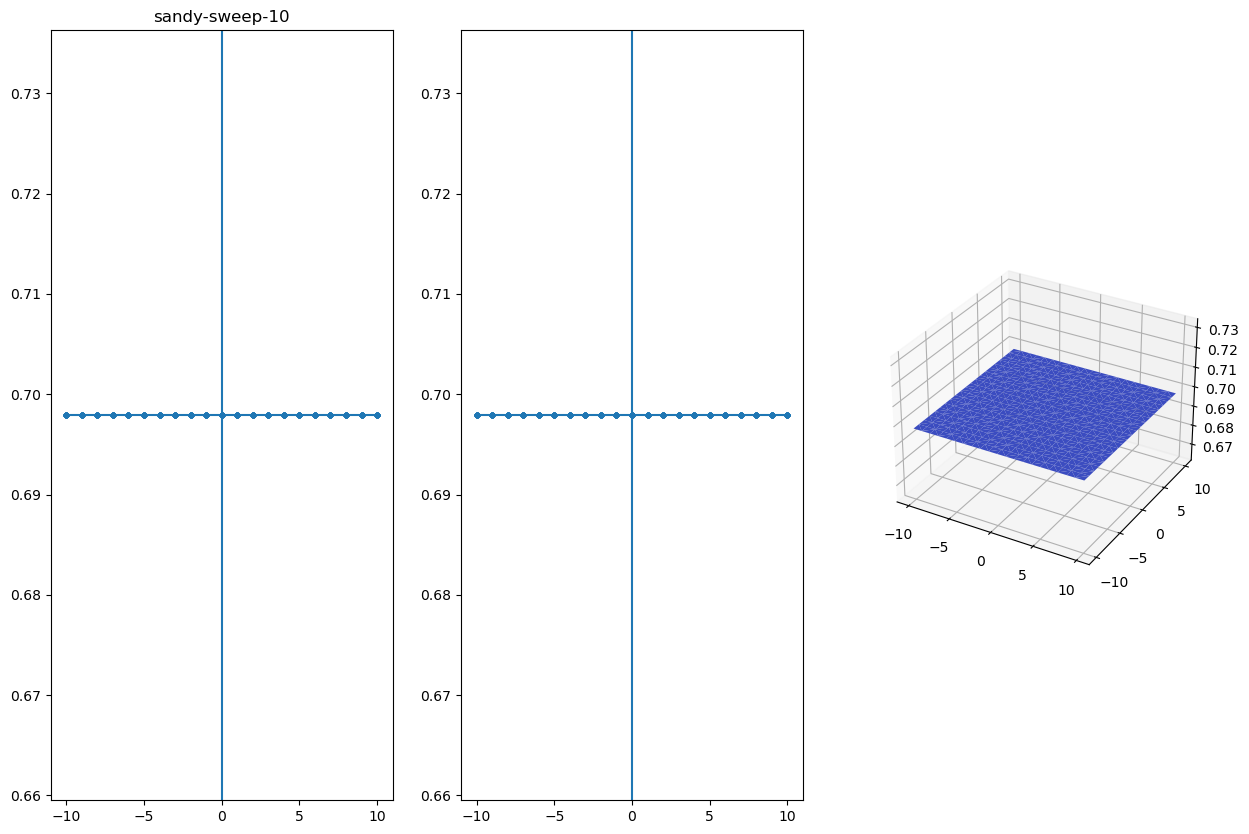

ValueError: This artifact contains more than one file, call `.download()` to get all files or call .get_path("filename").download()

In [6]:
for run in runs:
    model, table = list(run.logged_artifacts())[-2:]
    metricas = load_table_from_artifact(table)
    plt.figure(figsize = (15,10))
    plt.subplot(131)
    plt.title(run.name)
    plt.axvline(0)
    plt.plot(metricas["desp_h"], metricas["TestAccuracy"], '.-')
    plt.subplot(132)
    plt.axvline(0)
    plt.plot(metricas["desp_v"], metricas["TestAccuracy"], '.-')
    plt.subplot(133, projection = "3d")
    ax = plt.gca()
    ax.plot_trisurf(metricas["desp_h"], metricas["desp_v"], metricas["TestAccuracy"], cmap="coolwarm")
  
    plt.show()
    

wandb:   3 of 3 files downloaded.  
2023-02-28 10:08:16.226543: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-28 10:08:16.228049: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2023-02-28 10:08:16.228085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2023-02-28 10:08:16.233686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-02-28 10:08:16.233788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-02-28 10:08:16.233807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2023-02-28 10:08:16.250680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libr

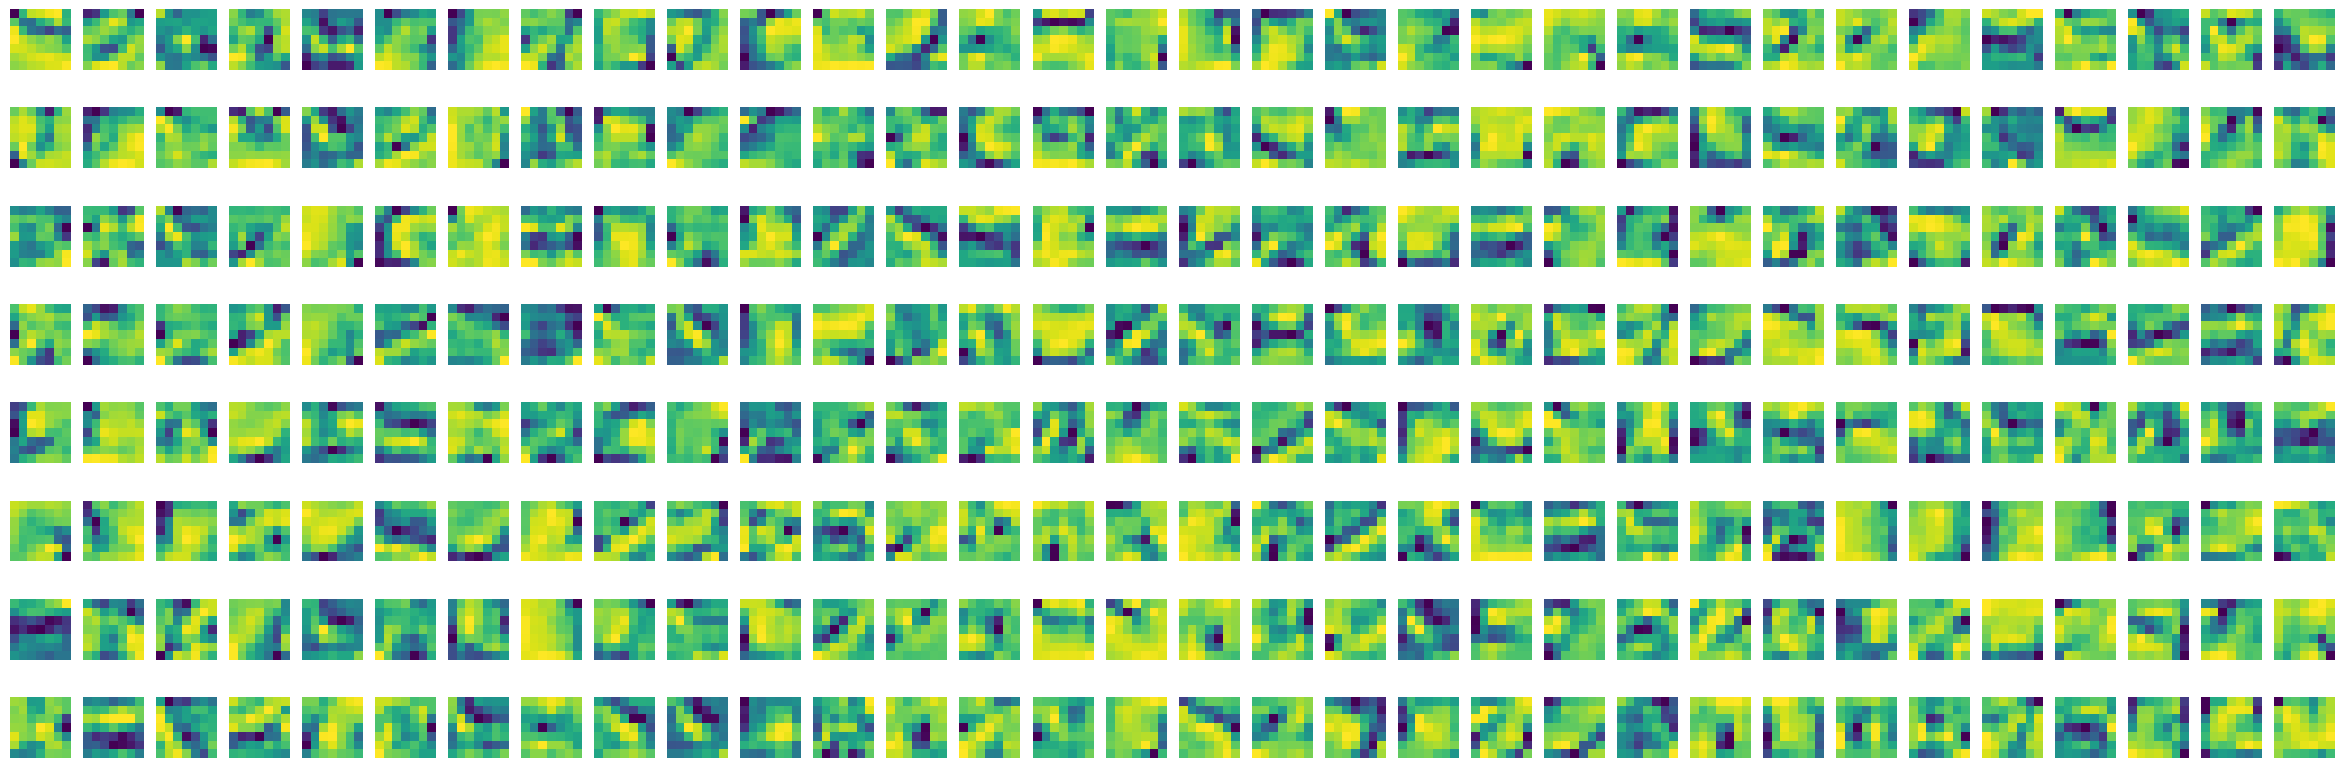

In [7]:
for run in runs:
    config = run.config
    model, table = list(run.logged_artifacts())[-2:]
    path = model.download()

    if "Pool" in run.name:
        clasificador = tf.keras.models.Sequential([layers.Conv2D(config["filters"], config["kernel_size"], activation = "relu", padding = "same" ,input_shape = (56,56,1),use_bias=False),# kernel_regularizer = regularizers.L1(0.01) #28x28
                                                    layers.MaxPooling2D(config["pooling"]),
                                                    layers.GlobalAveragePooling2D(),
                                                    layers.Dense(10, activation  = "softmax")
                                                ])

    else:
        clasificador = tf.keras.models.Sequential([layers.Conv2D(config["filters"], config["kernel_size"], activation = "relu", padding = "same" ,input_shape = (56,56,1),use_bias=False),# kernel_regularizer = regularizers.L1(0.01) #28x28
                                                    layers.GlobalAveragePooling2D(),
                                                    layers.Dense(10, activation  = "softmax")
                                                ])


    clasificador.load_weights(path + "/clasificador")

    for layer in clasificador.layers:
        if "conv" in layer.name:
            weights = layer.weights[0]
            weights = rearrange(weights, "kx ky ci co -> (ci co) kx ky")
            
            fig, axes = plt.subplots(config["filters"]//32,32)
            fig.set_figheight(10)
            fig.set_figwidth(30)
            for ax, filter in zip(axes.ravel(), weights):
                ax.imshow(filter)
                ax.axis("off")
        break
    
    break
    